In [1]:
import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import csv  

sns.set_style('whitegrid')
%matplotlib inline



from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder





In [132]:
# crawl the data from the website 


# puuid 
# puuid = "CUcPTA2mHGm2O_wFyZl0p5pC4s2OV-uXAt7cnyuK_ylHZNWuHji609Zv6dyvBKU4BuKJ1S1tIru4GA"
puuid = 'l29aAZyYOOHEX6oeQFvbuIE_bKtVVwZgwv27g0fDb9_zad8K1gr0v3p6CcI8KkxdV7mHlaj2Yrb8UA'

# Chỉ số trận đấu đầu tiên và cuối cùng trong danh sách
begin_indedf = 0
end_indedf = 100

# API key của bạn(riot chỉ cho hạn hơn 1 ngày nên khi dùng cần làm mới key)
api_key = "RGAPI-c76c2578-f4be-436c-a3ab-12a24ecf6fbb"


# Tạo đường dẫn truy vấn API lấy danh sách match id
requestUrl_for_matchIds = f"https://sea.api.riotgames.com/lol/match/v5/matches/by-puuid/{puuid}/ids?type=ranked&start={begin_indedf}&count={end_indedf}&api_key={api_key}"

# Gửi truy vấn API và phân tích phản hồi JSON
responseMatchId = requests.get(requestUrl_for_matchIds)
matchIds = json.loads(responseMatchId.text)

listInfo = []


keys_to_delete = ["challenges","perks","puuid","summonerId","riotIdName","riotIdTagline",'profileIcon', 'championTransform',
                   'participantId', 'spell1Casts', 'spell2Casts', 'spell3Casts' ,'spell4Casts', 'summoner1Casts', 'summoner2Casts', 
                   'summoner1Id', 'summoner2Id', 'summonerName', 'teamId', 'unrealKills', 'playerAugment1', 'playerAugment2', 'playerAugment3', 'playerAugment4',
       'playerSubteamId', 'subteamPlacement', 'eligibleForProgression','individualPosition','lane','role']

# Gửi truy vấn API lấy thông tin của từng match
for matchId in matchIds :
    requestUrl_for_matchInfor_byId = f"https://sea.api.riotgames.com/lol/match/v5/matches/{matchId}?api_key={api_key}"
    respondMatch = requests.get(requestUrl_for_matchInfor_byId)
    data = json.loads(respondMatch.text)
    # print(data.keys())
    if "info" in data: 
        dataPar = data["info"]["participants"] 
        # print(len(dataPar))
        for par in dataPar:
            par_copy = par.copy()  
            for key in keys_to_delete:
                par_copy.pop(key, None)
            listInfo.append(par_copy)





In [159]:
# crawl the data from the website 


# puuid 
puuid = "CUcPTA2mHGm2O_wFyZl0p5pC4s2OV-uXAt7cnyuK_ylHZNWuHji609Zv6dyvBKU4BuKJ1S1tIru4GA"
# puuid = 'l29aAZyYOOHEX6oeQFvbuIE_bKtVVwZgwv27g0fDb9_zad8K1gr0v3p6CcI8KkxdV7mHlaj2Yrb8UA'

# Chỉ số trận đấu đầu tiên và cuối cùng trong danh sách
begin_indedf = 0
end_indedf = 100

# API key của bạn(riot chỉ cho hạn hơn 1 ngày nên khi dùng cần làm mới key)
api_key = "RGAPI-c76c2578-f4be-436c-a3ab-12a24ecf6fbb"


# Tạo đường dẫn truy vấn API lấy danh sách match id
requestUrl_for_matchIds = f"https://sea.api.riotgames.com/lol/match/v5/matches/by-puuid/{puuid}/ids?type=ranked&start={begin_indedf}&count={end_indedf}&api_key={api_key}"

# Gửi truy vấn API và phân tích phản hồi JSON
responseMatchId = requests.get(requestUrl_for_matchIds)
matchIds = json.loads(responseMatchId.text)



keys_to_delete = ["challenges","perks","puuid","summonerId","riotIdName","riotIdTagline",'profileIcon', 'championTransform',
                   'participantId', 'spell1Casts', 'spell2Casts', 'spell3Casts' ,'spell4Casts', 'summoner1Casts', 'summoner2Casts', 
                   'summoner1Id', 'summoner2Id', 'summonerName', 'teamId', 'unrealKills', 'playerAugment1', 'playerAugment2', 'playerAugment3', 'playerAugment4',
       'playerSubteamId', 'subteamPlacement', 'eligibleForProgression','individualPosition','lane','role']

# Gửi truy vấn API lấy thông tin của từng match
for matchId in matchIds :
    requestUrl_for_matchInfor_byId = f"https://sea.api.riotgames.com/lol/match/v5/matches/{matchId}?api_key={api_key}"
    respondMatch = requests.get(requestUrl_for_matchInfor_byId)
    data = json.loads(respondMatch.text)
    # print(data.keys())
    if "info" in data: 
        dataPar = data["info"]["participants"] 
        # print(len(dataPar))
        for par in dataPar:
            par_copy = par.copy()  
            for key in keys_to_delete:
                par_copy.pop(key, None)
            listInfo.append(par_copy)





In [160]:
# write data to file
def array_to_csv(data_array, filename):
    keys = data_array[0].keys()  # Lấy danh sách các khóa từ đối tượng đầu tiên trong mảng
    with open(filename, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=keys)
        writer.writeheader()  # Viết header với các khóa làm cột
        for obj in data_array:
            writer.writerow(obj)
array_to_csv(listInfo, '../data_governance/data.csv')


In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.shape

(1980, 99)

In [4]:
df.head()

,allInPings,assistMePings,assists,baitPings,baronKills,basicPings,bountyLevel,champExperience,champLevel,championId,...,trueDamageTaken,turretKills,turretTakedowns,turretsLost,visionClearedPings,visionScore,visionWardsBoughtInGame,wardsKilled,wardsPlaced,win
0,0,0,14,0,0,0,2,17476,17,1,...,633,1,3,4,0,15,0,0,8,True
1,1,6,8,0,0,0,9,17090,17,24,...,754,4,5,4,0,15,0,2,9,True
2,0,3,12,0,0,0,0,15090,16,21,...,497,2,4,4,0,16,0,3,9,True
3,2,2,25,1,0,0,0,12958,14,89,...,294,1,3,4,0,52,2,3,21,True
4,0,14,9,0,1,0,1,15386,16,5,...,368,1,1,4,0,19,4,3,5,True


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1980 entries, 0 to 1979
Data columns (total 99 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   allInPings                      1980 non-null   int64  
 1   assistMePings                   1980 non-null   int64  
 2   assists                         1980 non-null   int64  
 3   baitPings                       1980 non-null   int64  
 4   baronKills                      1980 non-null   int64  
 5   basicPings                      1980 non-null   int64  
 6   bountyLevel                     1980 non-null   int64  
 7   champExperience                 1980 non-null   int64  
 8   champLevel                      1980 non-null   int64  
 9   championId                      1980 non-null   int64  
 10  championName                    1980 non-null   object 
 11  commandPings                    1980 non-null   int64  
 12  consumablesPurchased            19

In [6]:
def check_missing(df):
    # Check if the feature missing values 
    columns_with_missing_values_bool = df.select_dtypes(include=bool).columns[df.select_dtypes(include=bool).isna().any()]
    columns_with_missing_values_float = df.select_dtypes(include=float).columns[df.select_dtypes(include=float).isna().any()]
    columns_with_missing_values_int = df.select_dtypes(include=int).columns[df.select_dtypes(include=int).isna().any()]
    columns_with_missing_values_object = df.select_dtypes(include=object).columns[df.select_dtypes(include=object).isna().any()]

    # print column names that are missing
    print("Các cột bool có dữ liệu trống:", columns_with_missing_values_bool)
    print("Các cột float có dữ liệu trống:", columns_with_missing_values_float)
    print("Các cột int có dữ liệu trống:", columns_with_missing_values_int)
    print("Các cột object có dữ liệu trống:", columns_with_missing_values_object)

In [7]:
# Check duplicates
duplicates = df.duplicated()
dup = duplicates.sum()
dup

0

In [8]:

def select_types(x, type):
    return x.select_dtypes(include=type)
object_columns = select_types(df,'object')
bool_columns = select_types(df, 'bool')
float_columns = select_types(df, 'float')
int_colmns = select_types(df, 'int')


In [9]:
# split the data into groups by position 
top_df = df[df['teamPosition']=='TOP']
jg_df = df[df['teamPosition']=='JUNGLE']
mid_df = df[df['teamPosition']=='MIDDLE']
bot_df = df[df['teamPosition']=='BOTTOM']
sp_df = df[df['teamPosition']=='UTILITY']



In [10]:
# check and fill missing values if exist
# check_missing(top_df)
# check_missing(jg_df)
# check_missing(mid_df)
# check_missing(bot_df)
# check_missing(sp_df)

#fill missing columns top df with mode
top_df['totalAllyJungleMinionsKilled'].value_counts()
top_df['totalAllyJungleMinionsKilled'].fillna(0)
top_df['totalEnemyJungleMinionsKilled'].fillna(0)
#fill missing columns mid df with mode
mid_df['totalAllyJungleMinionsKilled'].value_counts()
mid_df['totalAllyJungleMinionsKilled'].fillna(0)
mid_df['totalEnemyJungleMinionsKilled'].fillna(0)

#fill missing columns bot df with mode
bot_df['totalAllyJungleMinionsKilled'].value_counts()
bot_df['totalAllyJungleMinionsKilled'].fillna(0)
bot_df['totalEnemyJungleMinionsKilled'].fillna(0)

#fill missing columns sp df with mode
sp_df['totalAllyJungleMinionsKilled'].value_counts()
sp_df['totalAllyJungleMinionsKilled'].fillna(0)
sp_df['totalEnemyJungleMinionsKilled'].fillna(0)

#fill missing columns jg df
jg_df['totalAllyJungleMinionsKilled'].value_counts()
jg_df['totalAllyJungleMinionsKilled'].fillna(value=jg_df['totalAllyJungleMinionsKilled'].median(), inplace=True)
jg_df['totalEnemyJungleMinionsKilled'].fillna(value=jg_df['totalEnemyJungleMinionsKilled'].median(), inplace=True)


C:\Users\anhda\AppData\Local\Temp\ipykernel_13212\3986462738.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jg_df['totalAllyJungleMinionsKilled'].fillna(value=jg_df['totalAllyJungleMinionsKilled'].median(), inplace=True)
C:\Users\anhda\AppData\Local\Temp\ipykernel_13212\3986462738.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jg_df['totalEnemyJungleMinionsKilled'].fillna(value=jg_df['totalEnemyJungleMinionsKilled'].median(), inplace=True)


In [11]:
# most chapions picked up 
def plot_chapions(df):   
    df['championName'].value_counts().plot(kind='bar', figsize=(14,6))
    plt.show()
 

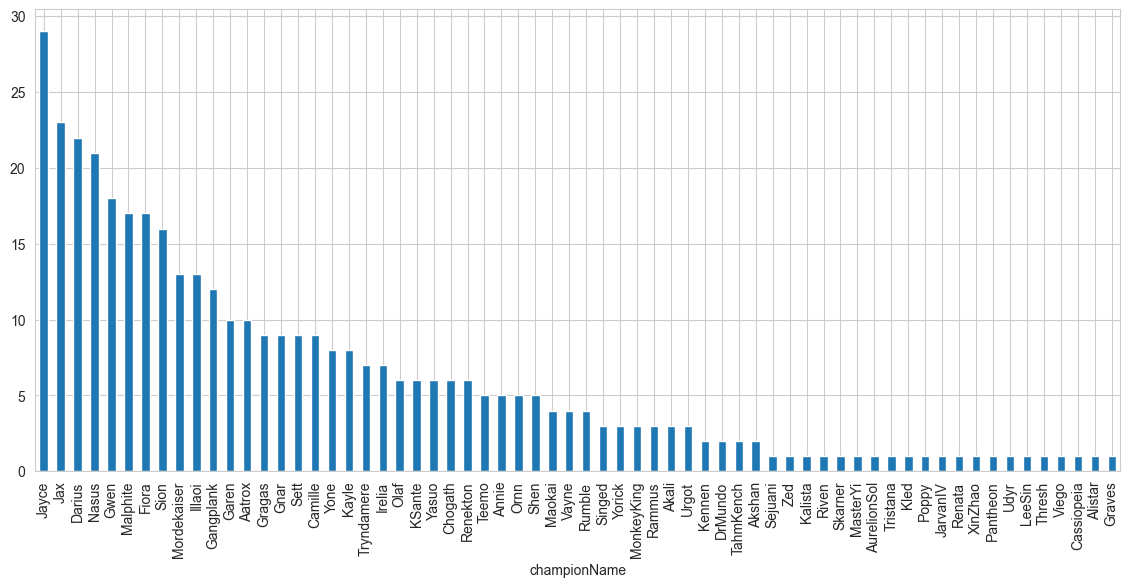

In [12]:
plot_chapions(top_df)


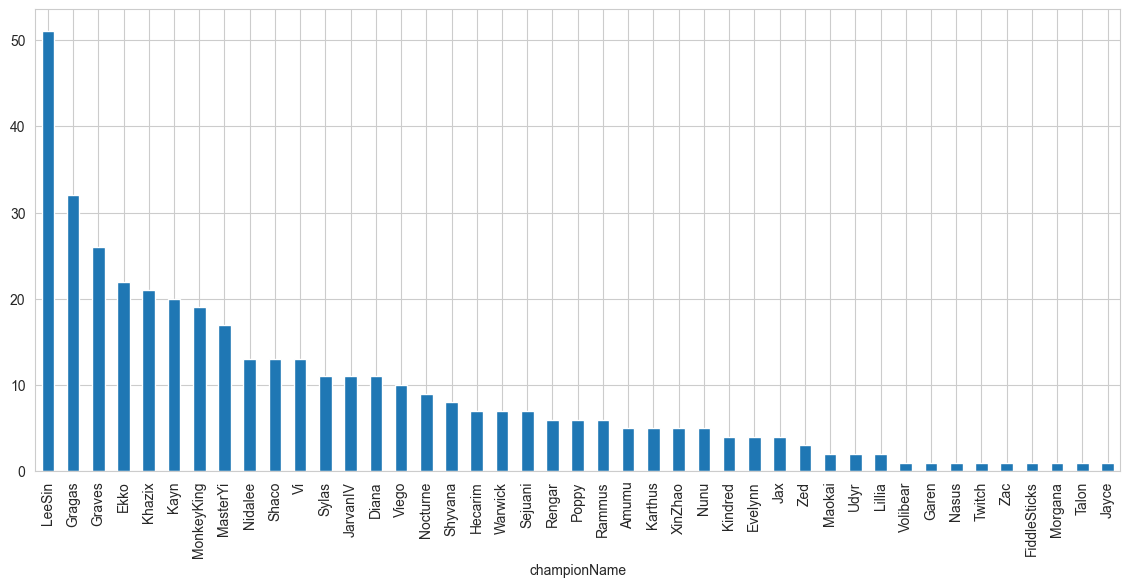

In [13]:
plot_chapions(jg_df)

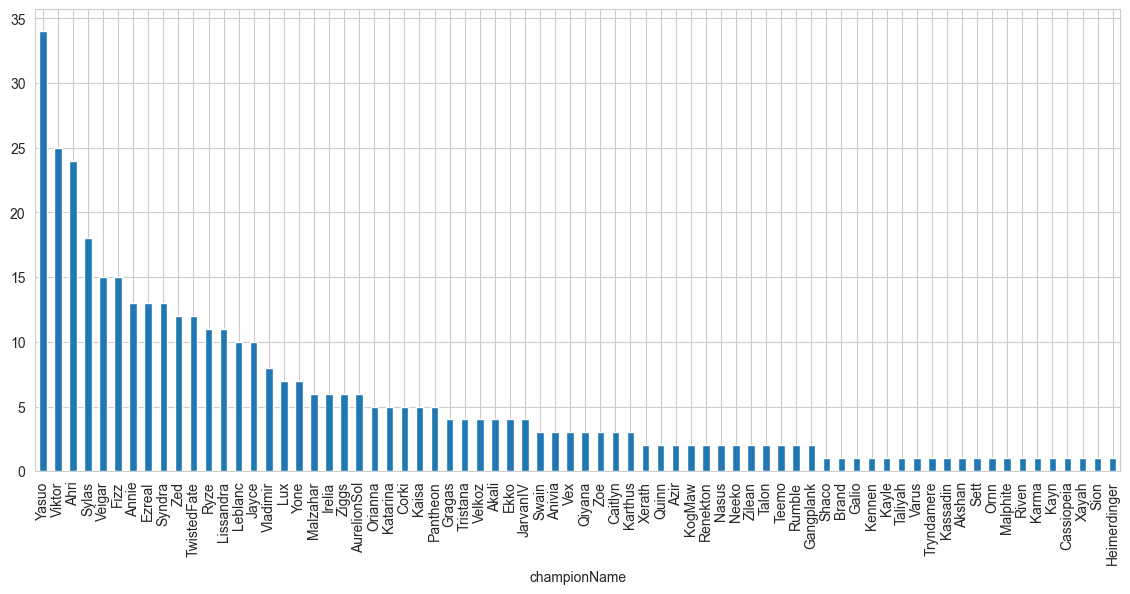

In [14]:
plot_chapions(mid_df)

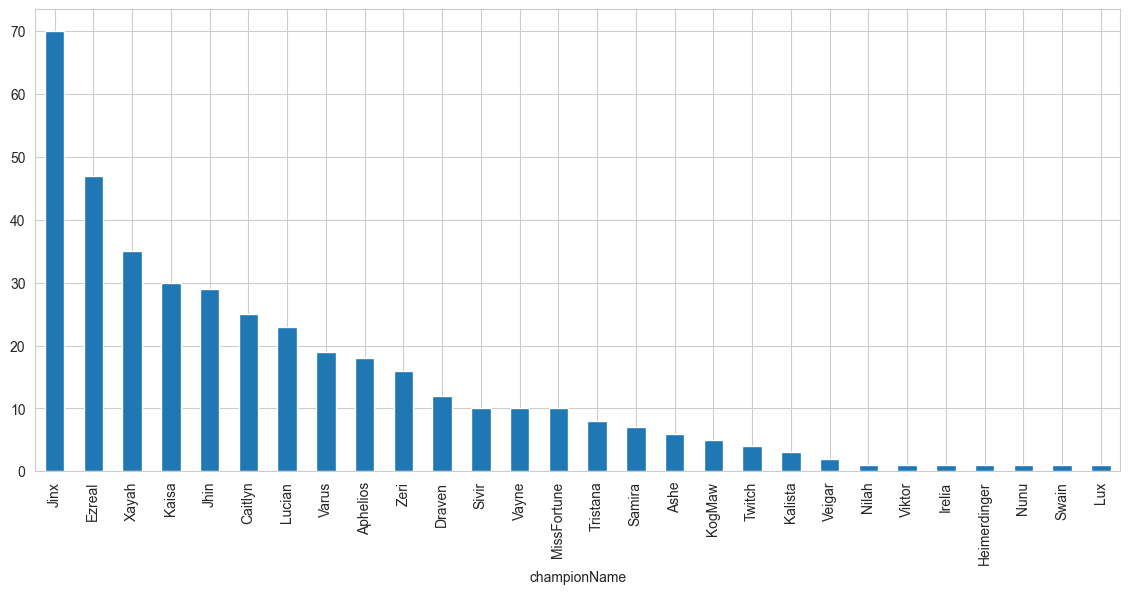

In [15]:
plot_chapions(bot_df)

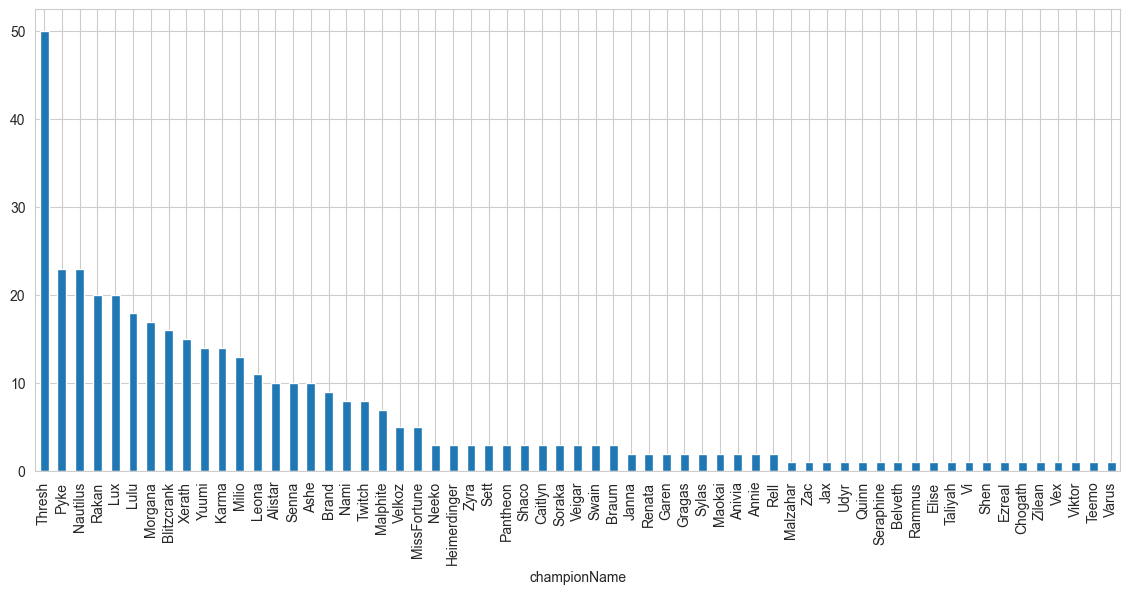

In [16]:
plot_chapions(sp_df)

In [17]:
# Champions win rates
def plot_champion_win_rates(df):
    champ_arr = df['championName'].value_counts().index
    win_rates = [] 
    for champ in champ_arr:
        win_rate = df.loc[(df['championName']==champ) &(df['win']==True)].shape[0]*100/df.loc[(df['championName']==champ)].shape[0]
        win_rates += [win_rate]
    fig = plt.figure(figsize=(14,6))
    plt.bar(champ_arr, win_rates)
    plt.xlabel('Champions')
    plt.ylabel('Win rates')
    plt.title('win rates of selected champions')
    plt.xticks(rotation=90)
    plt.subplots_adjust(bottom=0.2)
    plt.show()


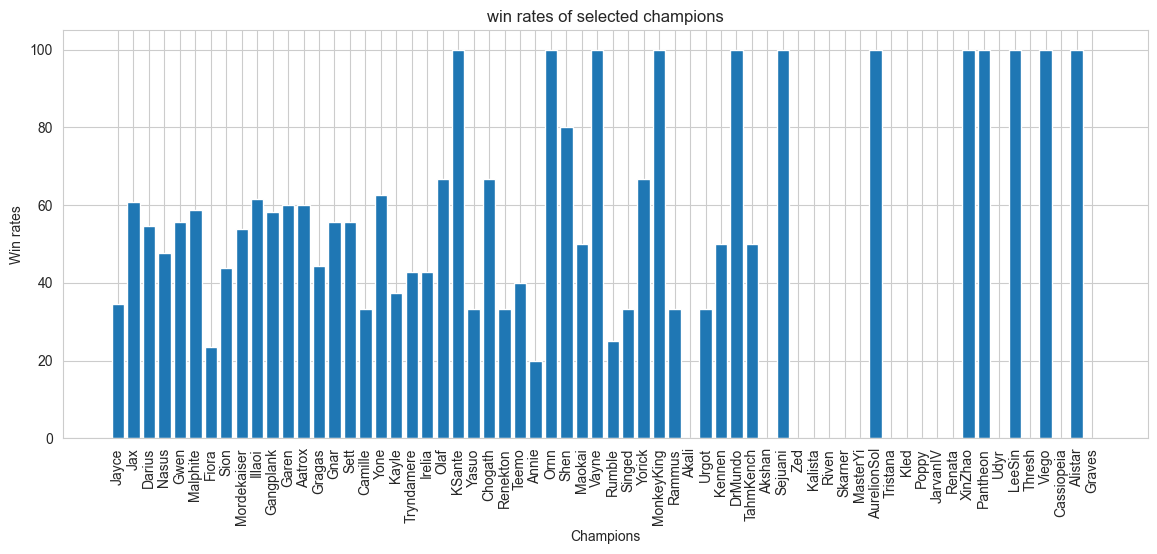

In [18]:
plot_champion_win_rates(top_df)

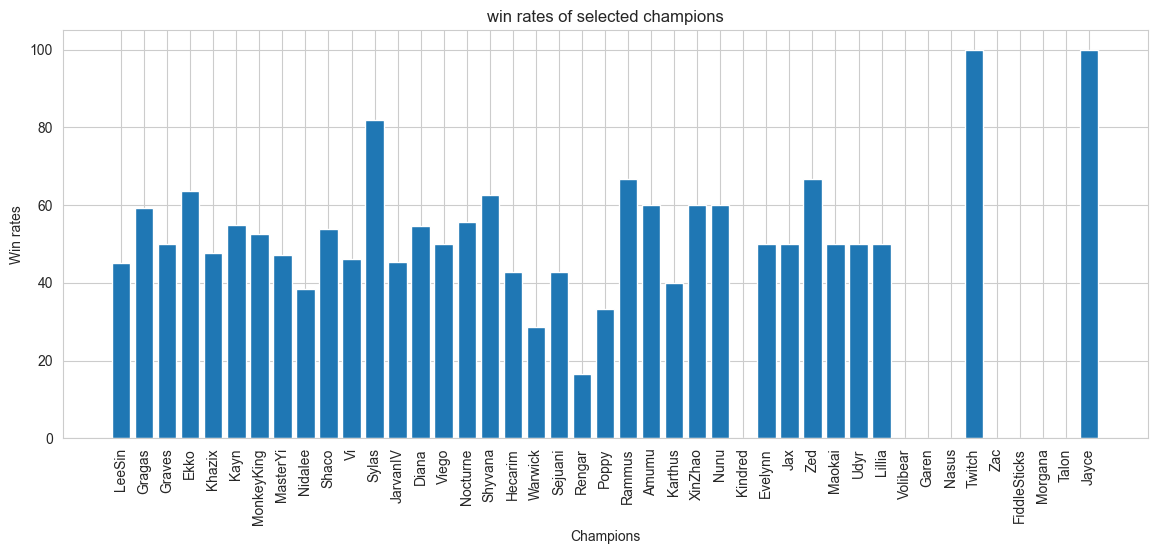

In [19]:
plot_champion_win_rates(jg_df)

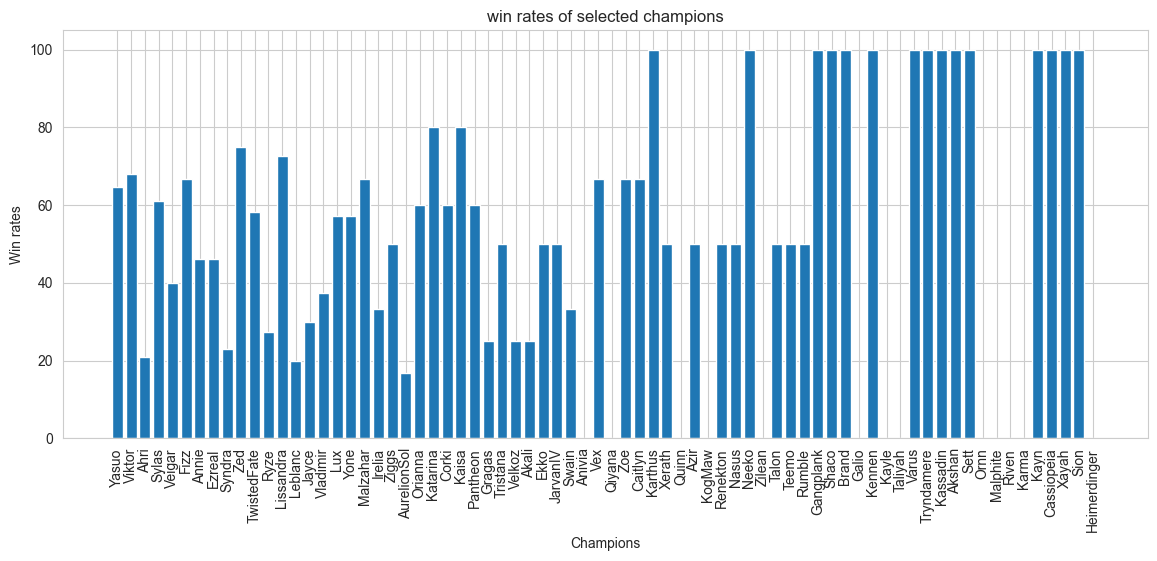

In [20]:
plot_champion_win_rates(mid_df)

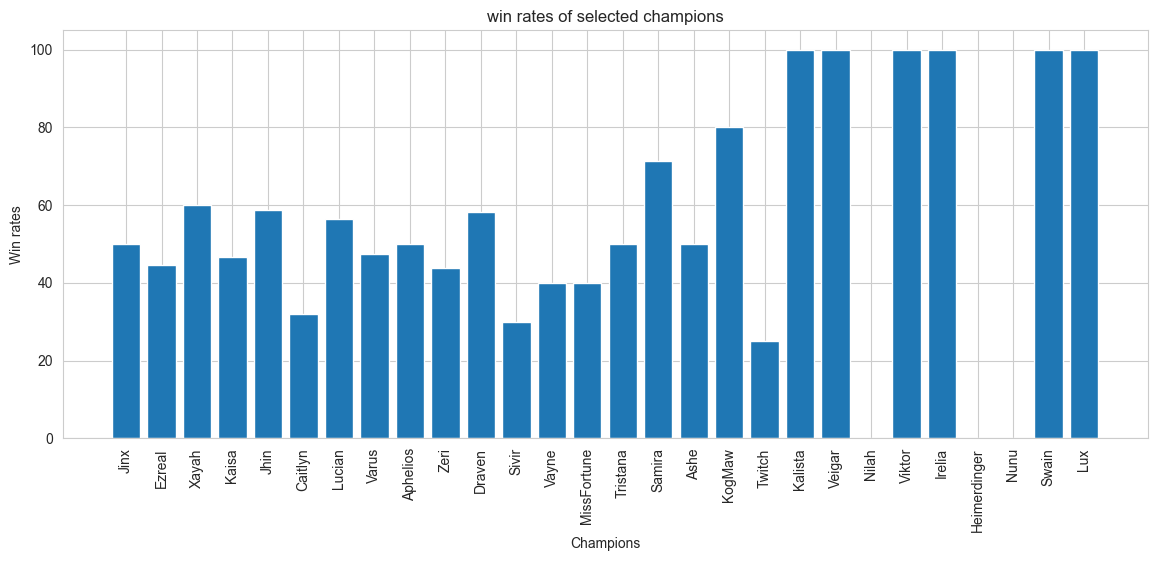

In [21]:
plot_champion_win_rates(bot_df)

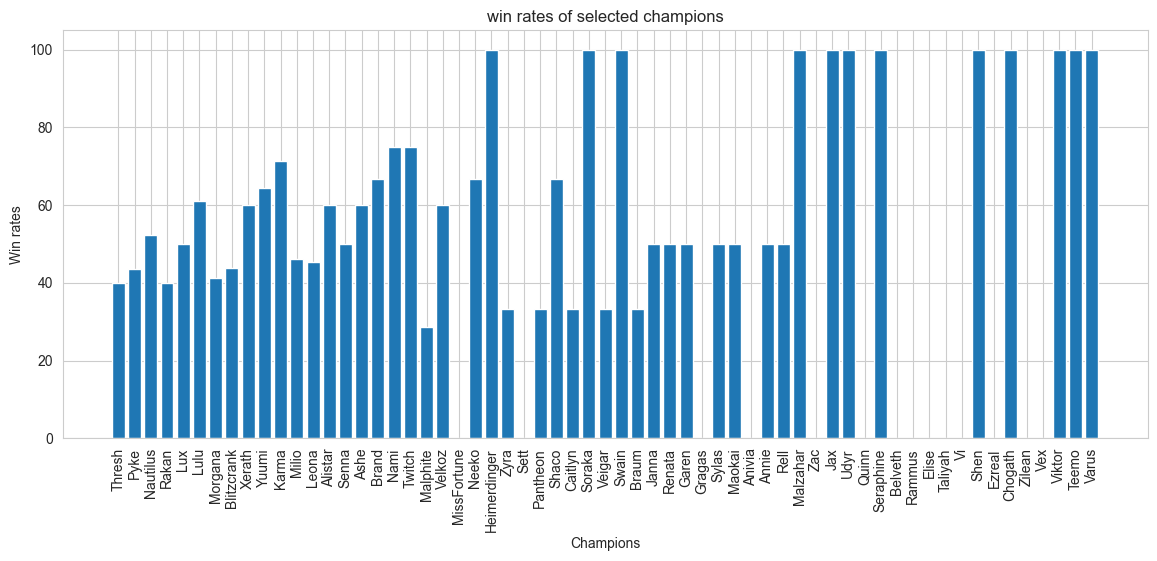

In [22]:
plot_champion_win_rates(sp_df)

In [23]:
# visualize kda of each position
def visualize_kda(df):
    kda_col= ['kills', 'deaths', 'assists']
    sum_lose = df.loc[df['win']==False,kda_col].sum(axis=0)
    sum_win = df.loc[df['win']==True,kda_col].sum(axis=0)

    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    ax.bar(np.arange(len(sum_lose)), sum_lose, width=0.3, color='red', label='lose')
    ax.bar(np.arange(len(sum_win)) + 0.3, sum_win, width=0.3, color='blue', label='win')
    ax.set_xticks(np.arange(len(sum_lose)) + 0.3/2)
    ax.set_xticklabels(sum_lose.index)
    ax.set_ylabel('kda')
    ax.legend()
    plt.show()

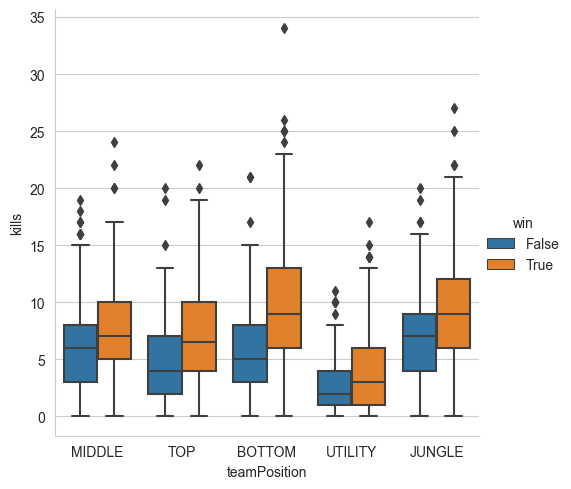

In [24]:
# With seaborn
sns.catplot(data=df, x='teamPosition', y='kills', hue='win', kind='box')

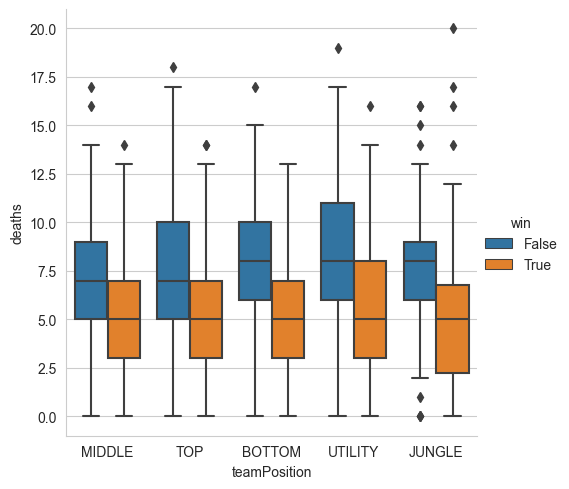

In [25]:
sns.catplot(data=df, x='teamPosition', y='deaths', hue='win', kind='box')

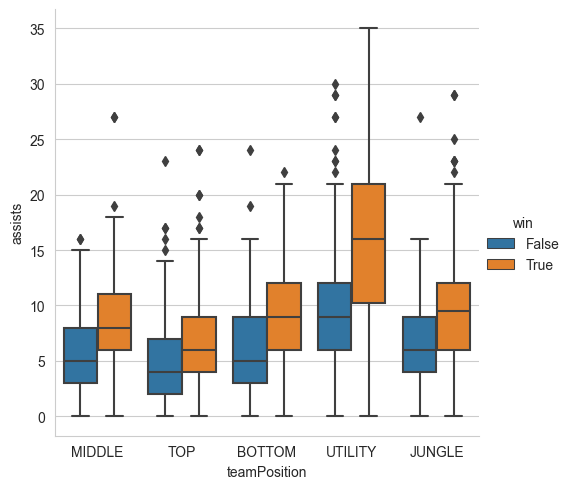

In [26]:
sns.catplot(data=df, x='teamPosition', y='assists', hue='win', kind='box')

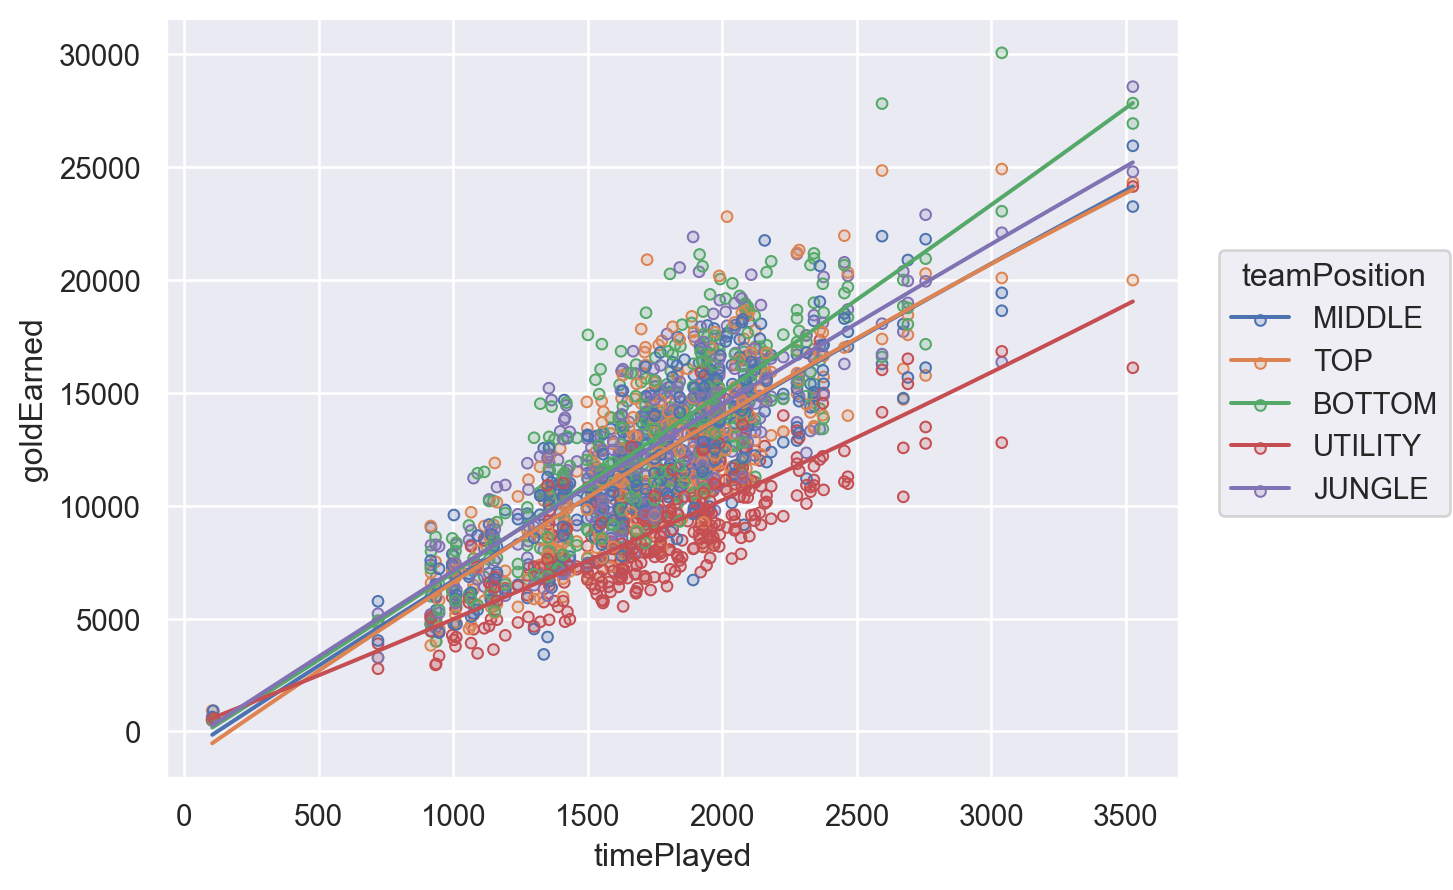

In [27]:
# goldEarned over time
(so.Plot(df, x='timePlayed', y='goldEarned', color='teamPosition')
 .add(so.Dots())
 .add(so.Line(), so.PolyFit())
)


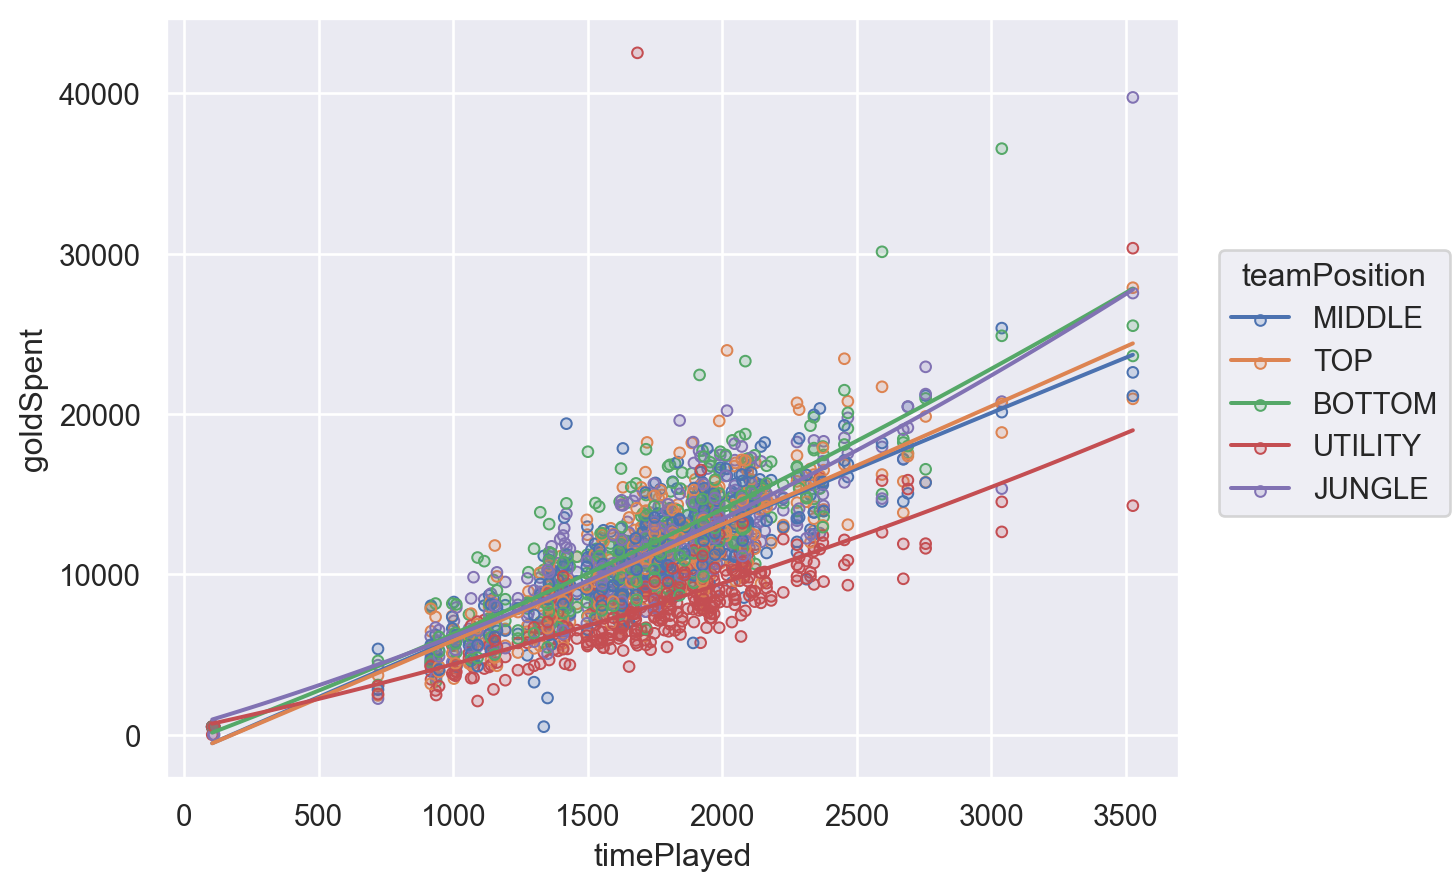

In [28]:
# goldSpent over time
(so.Plot(df, x='timePlayed', y='goldSpent', color='teamPosition')
 .add(so.Dots())
 .add(so.Line(), so.PolyFit())
)

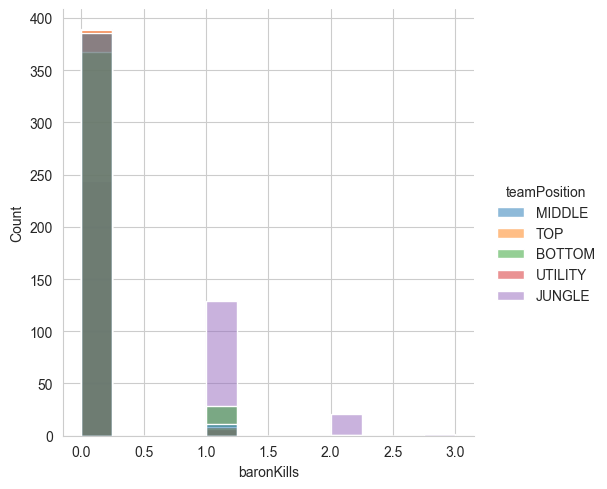

In [39]:
sns.displot(df, x='baronKills', hue='teamPosition')

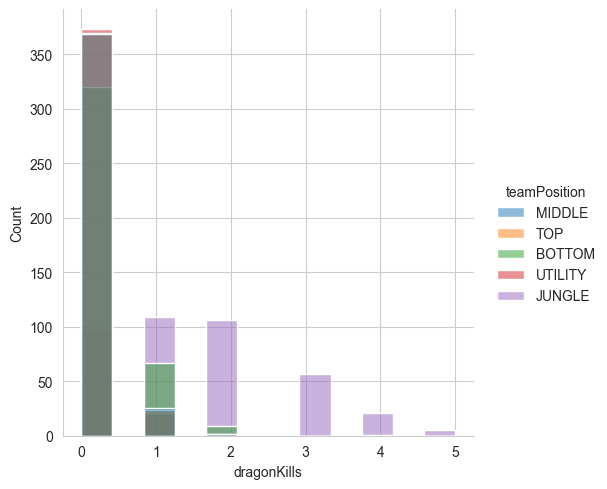

In [35]:
sns.displot(df, x='dragonKills', hue='teamPosition')

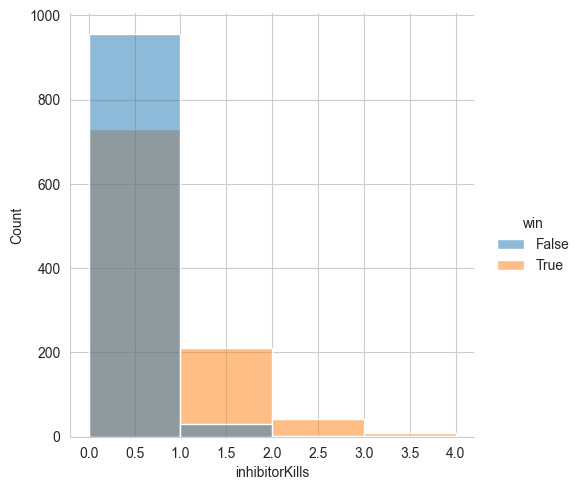

In [41]:
sns.displot(df, x='inhibitorKills', hue='win', bins=4)

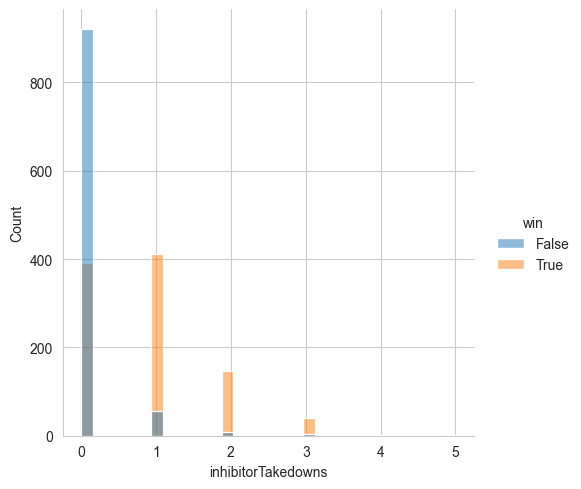

In [47]:
sns.displot(df, x='inhibitorTakedowns', hue='win')

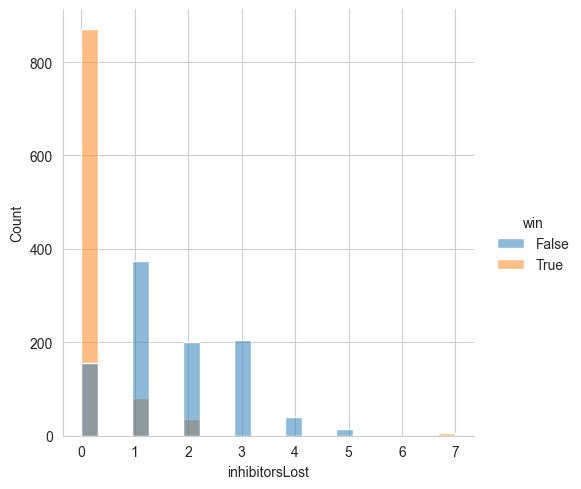

In [45]:
sns.displot(df, x='inhibitorsLost', hue='win')